In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
class MinNormSolver:
    MAX_ITER = 250
    STOP_CRIT = 1e-16

    def _min_norm_element_from2(v1v1, v1v2, v2v2):
        """
        Analytical solution for min_{c} |cx_1 + (1-c)x_2|_2^2
        d is the distance (objective) optimzed
        v1v1 = <x1,x1>
        v1v2 = <x1,x2>
        v2v2 = <x2,x2>
        """
        if v1v2 >= v1v1:
            # Case: Fig 1, third column
            gamma = 0.999
            cost = v1v1
            return gamma, cost
        if v1v2 >= v2v2:
            # Case: Fig 1, first column
            gamma = 0.001
            cost = v2v2
            return gamma, cost
        # Case: Fig 1, second column
        gamma = -1.0 * ( (v1v2 - v2v2) / (v1v1+v2v2 - 2*v1v2) )
        cost = v2v2 + gamma*(v1v2 - v2v2)
        return gamma, cost

    def _min_norm_2d(vecs, dps):
        """
        Find the minimum norm solution as combination of two points
        This solution is correct if vectors(gradients) lie in 2D
        ie. min_c |\sum c_i x_i|_2^2 st. \sum c_i = 1 , 1 >= c_1 >= 0 for all i, c_i + c_j = 1.0 for some i, j
        """
        dmin = 1e8
        for i in range(len(vecs)):
            for j in range(i+1,len(vecs)):
                if (i,j) not in dps:
                    dps[(i, j)] = 0.0
                    dps[(i,j)] = np.dot(vecs[i], vecs[j])
                    dps[(j, i)] = dps[(i, j)]
                if (i,i) not in dps:
                    dps[(i, i)] = 0.0
                    dps[(i,i)] = np.dot(vecs[i], vecs[i])
                if (j,j) not in dps:
                    dps[(j, j)] = 0.0
                    dps[(j, j)] = np.dot(vecs[j], vecs[j])
                c,d = MinNormSolver._min_norm_element_from2(dps[(i,i)], dps[(i,j)], dps[(j,j)])
                if d < dmin:
                    dmin = d
                    sol = [(i,j),c,d]
        return sol, dps

    def _projection2simplex(y):
        """
        Given y, it solves argmin_z |y-z|_2 st \sum z = 1 , 1 >= z_i >= 0 for all i
        """
        m = len(y)
        sorted_y = np.flip(np.sort(y), axis=0)
        tmpsum = 0.0
        tmax_f = (np.sum(y) - 1.0)/m
        for i in range(m-1):
            tmpsum+= sorted_y[i]
            tmax = (tmpsum - 1)/ (i+1.0)
            if tmax > sorted_y[i+1]:
                tmax_f = tmax
                break
        return np.maximum(y - tmax_f, np.zeros(y.shape))

    def _next_point(cur_val, grad, n):
        proj_grad = grad - ( np.sum(grad) / n )
        tm1 = -1.0*cur_val[proj_grad<0]/proj_grad[proj_grad<0]
        tm2 = (1.0 - cur_val[proj_grad>0])/(proj_grad[proj_grad>0])

        skippers = np.sum(tm1<1e-7) + np.sum(tm2<1e-7)
        t = 1
        if len(tm1[tm1>1e-7]) > 0:
            t = np.min(tm1[tm1>1e-7])
        if len(tm2[tm2>1e-7]) > 0:
            t = min(t, np.min(tm2[tm2>1e-7]))

        next_point = proj_grad*t + cur_val
        next_point = MinNormSolver._projection2simplex(next_point)
        return next_point

    def find_min_norm_element(vecs):
        """
        Given a list of vectors (vecs), this method finds the minimum norm element in the convex hull
        as min |u|_2 st. u = \sum c_i vecs[i] and \sum c_i = 1.
        It is quite geometric, and the main idea is the fact that if d_{ij} = min |u|_2 st u = c x_i + (1-c) x_j; the solution lies in (0, d_{i,j})
        Hence, we find the best 2-task solution, and then run the projected gradient descent until convergence
        """
        # Solution lying at the combination of two points
        dps = {}
        init_sol, dps = MinNormSolver._min_norm_2d(vecs, dps)

        n=len(vecs)
        sol_vec = np.zeros(n)
        sol_vec[init_sol[0][0]] = init_sol[1]
        sol_vec[init_sol[0][1]] = 1 - init_sol[1]

        if n < 3:
            # This is optimal for n=2, so return the solution
            return sol_vec , init_sol[2]

        iter_count = 0

        grad_mat = np.zeros((n,n))
        for i in range(n):
            for j in range(n):
                grad_mat[i,j] = dps[(i, j)]

        while iter_count < MinNormSolver.MAX_ITER:
            grad_dir = -1.0*np.dot(grad_mat, sol_vec)
            new_point = MinNormSolver._next_point(sol_vec, grad_dir, n)
            # Re-compute the inner products for line search
            v1v1 = 0.0
            v1v2 = 0.0
            v2v2 = 0.0
            for i in range(n):
                for j in range(n):
                    v1v1 += sol_vec[i]*sol_vec[j]*dps[(i,j)]
                    v1v2 += sol_vec[i]*new_point[j]*dps[(i,j)]
                    v2v2 += new_point[i]*new_point[j]*dps[(i,j)]
            nc, nd = MinNormSolver._min_norm_element_from2(v1v1, v1v2, v2v2)
            new_sol_vec = nc*sol_vec + (1-nc)*new_point
            change = new_sol_vec - sol_vec
            if np.sum(np.abs(change)) < MinNormSolver.STOP_CRIT:
                return sol_vec, nd
            sol_vec = new_sol_vec
        return sol_vec, nd

    def find_min_norm_element_FW(vecs):
        """
        Given a list of vectors (vecs), this method finds the minimum norm element in the convex hull
        as min |u|_2 st. u = \sum c_i vecs[i] and \sum c_i = 1.
        It is quite geometric, and the main idea is the fact that if d_{ij} = min |u|_2 st u = c x_i + (1-c) x_j; the solution lies in (0, d_{i,j})
        Hence, we find the best 2-task solution, and then run the Frank Wolfe until convergence
        """
        # Solution lying at the combination of two points
        dps = {}
        init_sol, dps = MinNormSolver._min_norm_2d(vecs, dps)

        n=len(vecs)
        sol_vec = np.zeros(n)
        sol_vec[init_sol[0][0]] = init_sol[1]
        sol_vec[init_sol[0][1]] = 1 - init_sol[1]

        if n < 3:
            # This is optimal for n=2, so return the solution
            return sol_vec , init_sol[2]

        iter_count = 0

        grad_mat = np.zeros((n,n))
        for i in range(n):
            for j in range(n):
                grad_mat[i,j] = dps[(i, j)]

        while iter_count < MinNormSolver.MAX_ITER:
            t_iter = np.argmin(np.dot(grad_mat, sol_vec))

            v1v1 = np.dot(sol_vec, np.dot(grad_mat, sol_vec))
            v1v2 = np.dot(sol_vec, grad_mat[:, t_iter])
            v2v2 = grad_mat[t_iter, t_iter]

            nc, nd = MinNormSolver._min_norm_element_from2(v1v1, v1v2, v2v2)
            new_sol_vec = nc*sol_vec
            new_sol_vec[t_iter] += 1 - nc

            change = new_sol_vec - sol_vec
            if np.sum(np.abs(change)) < MinNormSolver.STOP_CRIT:
                return sol_vec, nd
            sol_vec = new_sol_vec
            iter_count += 1
        return sol_vec, nd

In [3]:
def armijo_line_search(F, x_k, d_k, grad_F, gamma, alpha=0.5):
    t = 1.0
    while np.any(F(x_k + t * d_k) >  F(x_k) + t * (grad_F @ d_k) + 1/2 * gamma * t * np.linalg.norm(d_k)**2):
        t *= alpha
    return t

In [4]:
def MOGD_2(F, grad_F, x0, gamma=0.99, max_iter=500, epsilon=1e-8):
    x_k = x0
    t_k_pre = 0
    for k in range(max_iter):
        lambda_k, _ = MinNormSolver.find_min_norm_element_FW(grad_F(x_k))
        d_k = -np.sum(lambda_k[:, np.newaxis] * grad_F(x_k), axis=0)
        if np.allclose(d_k, 0):
            return x_k, k, t_k_pre
        else:
            t_k = armijo_line_search(F, x_k, d_k, grad_F(x_k), gamma)
            x_k = x_k + t_k * d_k
            t_k_pre = t_k

            if 0.5 * np.linalg.norm(d_k)**2 < epsilon:
                return x_k, k, t_k
    return x_k, max_iter, t_k

# Imbalance1

Số vòng lặp trung bình: 137.8828
Thời gian chạy trung bình: 29.3204 ms
Cỡ bước trung bình: 0.3951


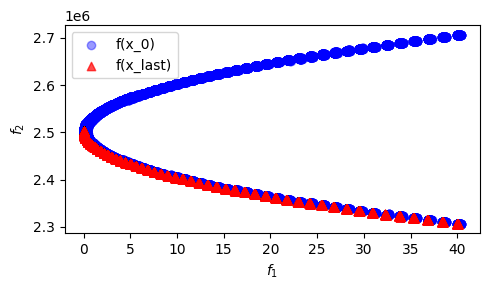

In [5]:
def F(x):
    f1 = 0.1*x[0]**2 + 10*x[1]**2
    f2 = (x[0]-50)**2 + 1000*(x[1]+50)**2
    return np.array([f1, f2])

def grad_F(x):
    df1_dx0 = 0.2*x[0]
    df1_dx1 = 20*x[1]
    df2_dx0 = 2*(x[0]-50)
    df2_dx1 = 2000*(x[1]+50)
    return np.array([[df1_dx0, df1_dx1], [df2_dx0, df2_dx1]])

def X():
    num_points = 100
    x1_range = np.linspace(-2, 2, num_points)
    x2_range = np.linspace(-2, 2, num_points)
    points = []
    for x1 in x1_range:
        for x2 in x2_range:
            points.append(np.array([x1, x2]))
    return points

x = X()
nmax = len(x)

x_opt = np.zeros((nmax, 2))
f_opt = np.zeros((nmax, 2))
iter = np.zeros(nmax)
times = np.zeros(nmax)
stepsize = np.zeros(nmax)

x_0 =  np.zeros((nmax, 2))
f_0 =  np.zeros((nmax, 2))

# Chạy MO Gradient Descent cho tất cả các điểm trong lưới
for i in range(nmax):
    x_0 = x[i]
    f_0[i] = F(x_0)
    start_time = time.time()
    x_opt[i], iter[i], stepsize[i] = MOGD_2(F, grad_F, x_0)
    times[i] = time.time() - start_time
    f_opt[i] = F(x_opt[i])

# Tính số vòng lặp trung bình
average_iter = np.mean(iter)
# Tính thời gian chạy trung bình
average_time = np.mean(times)
# Tính cỡ bước trung bình
step_size = np.mean(stepsize)

# In ra các kết quả
print(f"Số vòng lặp trung bình: {average_iter}")
print(f"Thời gian chạy trung bình: {average_time*1000:.4f} ms")
print(f"Cỡ bước trung bình: {step_size:.4f}")

# Vẽ biểu đồ kết quả
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

# Vẽ các điểm ban đầu và tối ưu
ax.scatter(f_0[:, 0], f_0[:, 1], c="b", alpha=0.4, label="f(x_0)")
ax.scatter(f_opt[:, 0], f_opt[:, 1], c="r", alpha=0.7, marker="^", label="f(x_last)")
ax.set_xlabel("$f_1$")
ax.set_ylabel("$f_2$")
ax.legend()
fig.tight_layout()
plt.show()

# Imbalance2

Số vòng lặp trung bình: 495.1155
Thời gian chạy trung bình: 171.0602 ms
Cỡ bước trung bình: 0.0039


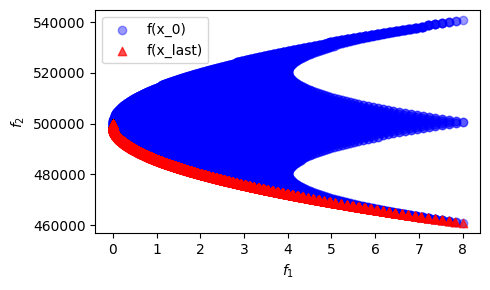

In [6]:
def F(x):
    f1 = x[0]**2 + x[1]**2
    f2 = 100*(x[0]-50)**2 + 100*(x[1]+50)**2
    return np.array([f1, f2])

def grad_F(x):
    df1_dx0 = 2*x[0]
    df1_dx1 = 2*x[1]
    df2_dx0 = 200*(x[0]-50)
    df2_dx1 = 200*(x[1]+50)
    return np.array([[df1_dx0, df1_dx1], [df2_dx0, df2_dx1]])

def X():
    num_points = 100
    x1_range = np.linspace(-2, 2, num_points)
    x2_range = np.linspace(-2, 2, num_points)
    points = []
    for x1 in x1_range:
        for x2 in x2_range:
            points.append(np.array([x1, x2]))
    return points

x = X()
nmax = len(x)

x_opt = np.zeros((nmax, 2))
f_opt = np.zeros((nmax, 2))
iter = np.zeros(nmax)
times = np.zeros(nmax)
stepsize = np.zeros(nmax)

x_0 =  np.zeros((nmax, 2))
f_0 =  np.zeros((nmax, 2))

# Chạy MO Gradient Descent cho tất cả các điểm trong lưới
for i in range(nmax):
    x_0 = x[i]
    f_0[i] = F(x_0)
    start_time = time.time()
    x_opt[i], iter[i], stepsize[i] = MOGD_2(F, grad_F, x_0)
    times[i] = time.time() - start_time
    f_opt[i] = F(x_opt[i])

# Tính số vòng lặp trung bình
average_iter = np.mean(iter)
# Tính thời gian chạy trung bình
average_time = np.mean(times)
# Tính cỡ bước trung bình
step_size = np.mean(stepsize)

# In ra các kết quả
print(f"Số vòng lặp trung bình: {average_iter}")
print(f"Thời gian chạy trung bình: {average_time*1000:.4f} ms")
print(f"Cỡ bước trung bình: {step_size:.4f}")

# Vẽ biểu đồ kết quả
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

# Vẽ các điểm ban đầu và tối ưu
ax.scatter(f_0[:, 0], f_0[:, 1], c="b", alpha=0.4, label="f(x_0)")
ax.scatter(f_opt[:, 0], f_opt[:, 1], c="r", alpha=0.7, marker="^", label="f(x_last)")
ax.set_xlabel("$f_1$")
ax.set_ylabel("$f_2$")
ax.legend()
fig.tight_layout()
plt.show()

# JOS1

Số vòng lặp trung bình: 8.482039
Thời gian chạy trung bình: 1.2778 ms
Cỡ bước trung bình: 1.0000


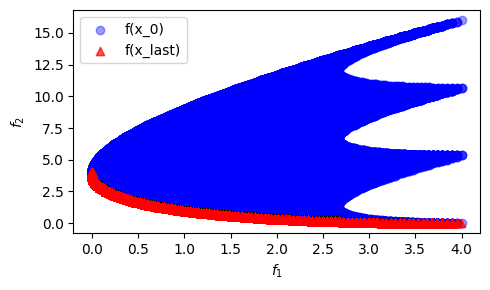

In [7]:
def F(x):
    f1 = (x[0]**2 + x[1]**2 + x[2]**2)/3
    f2 = ((x[0] - 2)**2 + (x[1] - 2)**2 + (x[2] - 2)**2)/3
    return np.array([f1, f2])

def grad_F(x):
    df1_dx0 = 2*x[0]/3
    df1_dx1 = 2*x[1]/3
    df1_dx2 = 2*x[2]/3
    df2_dx0 = 2*(x[0] - 2)/3
    df2_dx1 = 2*(x[1] - 2)/3
    df2_dx2 = 2*(x[2] - 2)/3
    return np.array([[df1_dx0, df1_dx1, df1_dx2], [df2_dx0, df2_dx1, df2_dx2]])

def X():
    num_points = 100
    x1_range = np.linspace(-2, 2, num_points)
    x2_range = np.linspace(-2, 2, num_points)
    x3_range = np.linspace(-2, 2, num_points)
    points = []
    for x1 in x1_range:
        for x2 in x2_range:
            for x3 in x3_range:
                points.append(np.array([x1, x2, x3]))
    return points

x = X()
nmax = len(x)

x_opt = np.zeros((nmax, 3))
f_opt = np.zeros((nmax, 2))
iter = np.zeros(nmax)
times = np.zeros(nmax)
stepsize = np.zeros(nmax)

x_0 =  np.zeros((nmax, 3))
f_0 =  np.zeros((nmax, 2))

# Chạy MO Gradient Descent cho tất cả các điểm trong lưới
for i in range(nmax):
    x_0 = x[i]
    f_0[i] = F(x_0)
    start_time = time.time()
    x_opt[i], iter[i], stepsize[i] = MOGD_2(F, grad_F, x_0)
    times[i] = time.time() - start_time
    f_opt[i] = F(x_opt[i])

# Tính số vòng lặp trung bình
average_iter = np.mean(iter)
# Tính thời gian chạy trung bình
average_time = np.mean(times)
# Tính cỡ bước trung bình
step_size = np.mean(stepsize)

# In ra các kết quả
print(f"Số vòng lặp trung bình: {average_iter}")
print(f"Thời gian chạy trung bình: {average_time*1000:.4f} ms")
print(f"Cỡ bước trung bình: {step_size:.4f}")

# Vẽ biểu đồ kết quả
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

# Vẽ các điểm ban đầu và tối ưu
ax.scatter(f_0[:, 0], f_0[:, 1], c="b", alpha=0.4, label="f(x_0)")
ax.scatter(f_opt[:, 0], f_opt[:, 1], c="r", alpha=0.7, marker="^", label="f(x_last)")
ax.set_xlabel("$f_1$")
ax.set_ylabel("$f_2$")
ax.legend()
fig.tight_layout()
plt.show()

# TRIDIA1

Số vòng lặp trung bình: 15.146248
Thời gian chạy trung bình: 15.3125 ms
Cỡ bước trung bình: 0.0916


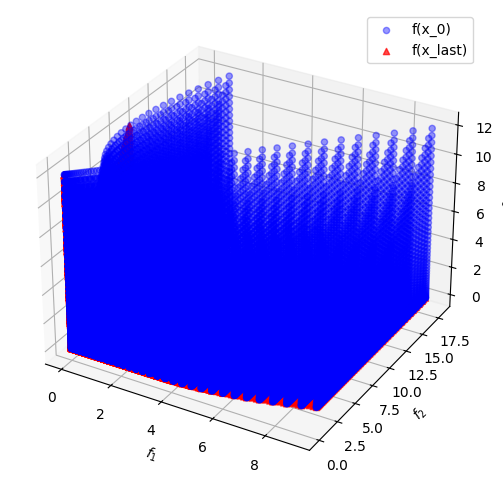

In [8]:
def F(x):
    f1 = (2*x[0]-1)**2
    f2 = 2*(2*x[0] - x[1])**2
    f3 = 3*(x[1] - x[2])**2
    return np.array([f1, f2, f3])

def grad_F(x):
    df1_dx0 = 4*(2*x[0]-1)
    df1_dx1 = 0
    df1_dx2 = 0
    df2_dx0 = 8*(2*x[0] - x[1])
    df2_dx1 = 4*(x[1] - 2*x[0])
    df2_dx2 = 0
    df3_dx0 = 0
    df3_dx1 = 6*(x[1] - x[2])
    df3_dx2 = 6*(x[2] - x[1])
    return np.array([[df1_dx0, df1_dx1, df1_dx2], [df2_dx0, df2_dx1, df2_dx2], [df3_dx0, df3_dx1, df3_dx2]])

def X():
    num_points = 50
    x1_range = np.linspace(-1, 1, num_points)
    x2_range = np.linspace(-1, 1, num_points)
    x3_range = np.linspace(-1, 1, num_points)
    points = []
    for x1 in x1_range:
        for x2 in x2_range:
            for x3 in x3_range:
                points.append(np.array([x1, x2, x3]))
    return points

x = X()
nmax = len(x)

x_opt = np.zeros((nmax, 3))
f_opt = np.zeros((nmax, 3))
iter = np.zeros(nmax)
times = np.zeros(nmax)
stepsize = np.zeros(nmax)

x_0 =  np.zeros((nmax, 3))
f_0 =  np.zeros((nmax, 3))

# Chạy MO Gradient Descent cho tất cả các điểm trong lưới
for i in range(nmax):
    x_0 = x[i]
    f_0[i] = F(x_0)
    start_time = time.time()
    x_opt[i], iter[i], stepsize[i] = MOGD_2(F, grad_F, x_0)
    times[i] = time.time() - start_time
    f_opt[i] = F(x_opt[i])

# Tính số vòng lặp trung bình
average_iter = np.mean(iter)
# Tính thời gian chạy trung bình
average_time = np.mean(times)
# Tính cỡ bước trung bình
step_size = np.mean(stepsize)

# In ra các kết quả
print(f"Số vòng lặp trung bình: {average_iter}")
print(f"Thời gian chạy trung bình: {average_time*1000:.4f} ms")
print(f"Cỡ bước trung bình: {step_size:.4f}")

# Vẽ biểu đồ kết quả
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111, projection='3d')


# Vẽ các điểm ban đầu và tối ưu
ax.scatter(f_0[:, 0], f_0[:, 1], f_0[:, 2], c="b", alpha=0.4, label="f(x_0)")
ax.scatter(f_opt[:, 0], f_opt[:, 1], f_opt[:, 2], c="r", alpha=0.7, marker="^", label="f(x_last)")
ax.set_xlabel("$f_1$")
ax.set_ylabel("$f_2$")
ax.set_zlabel("$f_3$")
ax.legend()
fig.tight_layout()
plt.show()